In [51]:
pip install pyproj

Note: you may need to restart the kernel to use updated packages.


# Projet Chlordécone

**Objectif :** construire un pipeline reproductible (ingénierie + analyse) sur les données chlordécone.

Ce notebook est structuré en 4 étapes :
1. Chargement & compréhension des données
2. Data preparation (types, dates, censures, valeurs manquantes, valeurs aberrantes, contrôles)
3. Analyses utiles à la décision (communes, sols, temporalité)
4. Exports pour Power BI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import kruskal, chi2_contingency


## 1) Chargement des données


In [2]:
# Chemin GitHub :
# data/source/BaseCLD2026.csv
chemin = "data/source/BaseCLD2026.csv"

chlordecone = pd.read_csv(chemin, sep=";", dtype=str, encoding="utf-8")
chlordecone.shape, chlordecone.head()


((31126, 22),
       ID ANNEE   COMMU_LAB       RAIN Sol_simple  \
 0  20143  2010  GROS-MORNE  2000-3000    Andosol   
 1  20143  2010  GROS-MORNE  2000-3000    Andosol   
 2  20143  2010  GROS-MORNE  2000-3000    Andosol   
 3  20143  2010  GROS-MORNE  2000-3000    Andosol   
 4  20143  2010  GROS-MORNE  2000-3000    Andosol   
 
                                             type_sol Date_prelevement  \
 0  Intergrades Sols … allophane relativement ‚vol...       24/05/2007   
 1  Intergrades Sols … allophane relativement ‚vol...       24/05/2007   
 2  Intergrades Sols … allophane relativement ‚vol...       24/05/2007   
 3  Intergrades Sols … allophane relativement ‚vol...       24/05/2007   
 4  Intergrades Sols … allophane relativement ‚vol...       24/05/2007   
 
   Date_enregistrement Date_analyse Operateur_chld  ... Taux_5b_hydro  \
 0          24/05/2007   24/05/2007              =  ...          0,07   
 1          24/05/2007   24/05/2007              =  ...          0,07   
 

## 2) Diagnostic initial


In [3]:
chlordecone.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31126 entries, 0 to 31125
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     31126 non-null  object
 1   ANNEE                  31126 non-null  object
 2   COMMU_LAB              30828 non-null  object
 3   RAIN                   31126 non-null  object
 4   Sol_simple             31052 non-null  object
 5   type_sol               28517 non-null  object
 6   Date_prelevement       31126 non-null  object
 7   Date_enregistrement    31126 non-null  object
 8   Date_analyse           31126 non-null  object
 9   Operateur_chld         31126 non-null  object
 10  Taux_Chlordecone       31126 non-null  object
 11  Operateur_5b           31126 non-null  object
 12  Taux_5b_hydro          31114 non-null  object
 13  histoBanane_Histo_ban  13143 non-null  object
 14  mnt_tpi_mean           31098 non-null  object
 15  mnt_tri_mean       

## 3) Data preparation


### 3.1 Nettoyage de base + noms de colonnes


In [4]:
chlordecone.columns = [c.strip() for c in chlordecone.columns]


### 3.2 Suppression des doublons


In [5]:
#traitement des doublons eventuels

chlordecone.duplicated().sum()
chlordecone = chlordecone.drop_duplicates()


### 3.3 Conversion des dates (texte en datetime)

- `dayfirst=True` pour les formats français (jour/mois/année).
- `errors='coerce'` transforme les dates non conformes en `NaT` (manquantes).


In [6]:
#J'ai convertit les colonnes dates dans un format date exploitable car elles étaient en format texte
date_cols = [
    "Date_prelevement",
    "Date_enregistrement",
    "Date_analyse"
]

for col in date_cols:
    chlordecone[col] = pd.to_datetime(chlordecone[col], dayfirst=True, errors="coerce")

### 3.4 Conversion des colonnes numériques (gestion virgule, inf, tokens non numériques)


In [7]:
#J'ai convertit les colonnes numérique dans le bon format pour pouvoir les exploiter ensuite
def to_float(series):
    s = (
        series.astype(str)
              .str.replace(",", ".", regex=False)
              .str.strip()
              .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    )
    return pd.to_numeric(s, errors="coerce")


num_cols = [
    "Taux_Chlordecone", "Taux_5b_hydro",
    "mnt_tpi_mean", "mnt_tri_mean", "mnt_rugosite_mean",
    "mnt_ombrage_mean", "mnt_exposition_mean", "mnt_pente_mean",
    "X", "Y"
]

for col in num_cols:
    chlordecone[col] = to_float(chlordecone[col])


### 3.5 Valeurs censurées (opérateur `<`)

Quand `Operateur = '<'`, la valeur est sous la limite de détection.  
J'ai donc remplacé les valeurs inférieures à la limite de détection par la moitié de cette limite afin de conserver l’information sans biaiser les résultats.


In [8]:
chlordecone["chlordecone_censure"] = chlordecone["Operateur_chld"] == "<"
chlordecone["hydro5b_censure"] = chlordecone["Operateur_5b"] == "<"

chlordecone["Taux_Chlordecone_num"] = np.where(
    chlordecone["chlordecone_censure"],
    chlordecone["Taux_Chlordecone"] / 2,
    chlordecone["Taux_Chlordecone"]
)

chlordecone["Taux_5b_hydro_num"] = np.where(
    chlordecone["hydro5b_censure"],
    chlordecone["Taux_5b_hydro"] / 2,
    chlordecone["Taux_5b_hydro"]
)


### 3.6 Contrôle de cohérence des dates


In [9]:
#Contrôle de la cohérence des dates et je les supprime si incohérente

chlordecone["date_incoherente"] = chlordecone["Date_prelevement"] > chlordecone["Date_analyse"]
chlordecone["date_incoherente"].value_counts()

chlordecone = chlordecone[~chlordecone["date_incoherente"]]


### 3.7 Valeurs manquantes : diagnostic


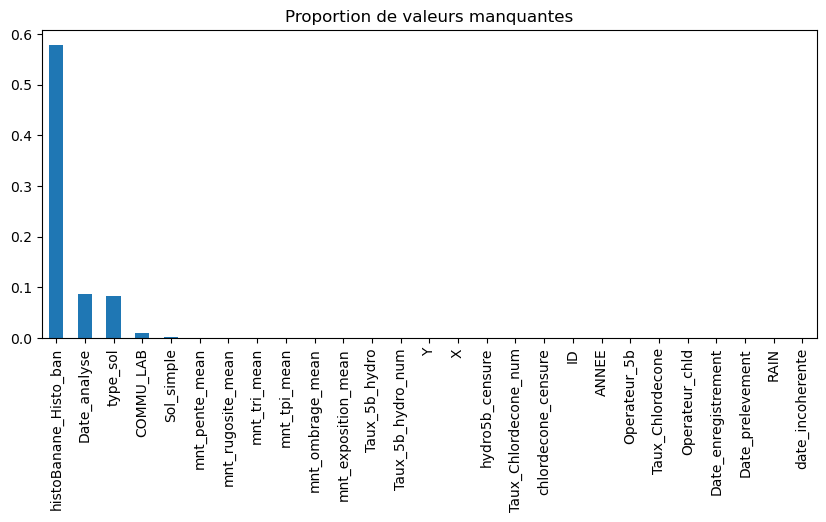

In [10]:
val_manquante = chlordecone.isna().mean().sort_values(ascending=False)
val_manquante.head(10)

val_manquante.plot(kind="bar", figsize=(10,4))
plt.title("Proportion de valeurs manquantes")
plt.show()

### 3.8 Valeurs aberrantes : diagnostic+ version capée

But : visualiser les extrêmes.  
Ensuite, on produit une version **capée** (p1–p99) pour stabiliser les analyses agrégées.


C:\Users\theor\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


                        count        mean        std        min         1%  \
Taux_Chlordecone_num  31029.0    0.664627   1.560979   0.000500   0.000500   
Taux_5b_hydro         31006.0         inf        NaN   0.000000   0.000000   
mnt_pente_mean        31001.0   20.257997  13.370751   0.000000   1.463683   
mnt_tri_mean          31001.0    4.309965   2.858177   0.000000   0.323299   
mnt_tpi_mean          31001.0    0.212423   2.578047 -29.065807  -6.750000   
mnt_rugosite_mean     31001.0   13.433114   8.621548   0.000000   1.000000   
mnt_ombrage_mean      31001.0  175.090441  27.863979  24.789383  96.000000   
mnt_exposition_mean   31001.0  170.185005  95.779608   0.000000   3.179832   

                              5%         50%         95%         99%  \
Taux_Chlordecone_num    0.000500    0.003100    4.200000    7.208680   
Taux_5b_hydro           0.001000    0.003300    0.124000         NaN   
mnt_pente_mean          3.849370   17.893784   44.147480   66.407810   
mnt_tri_m

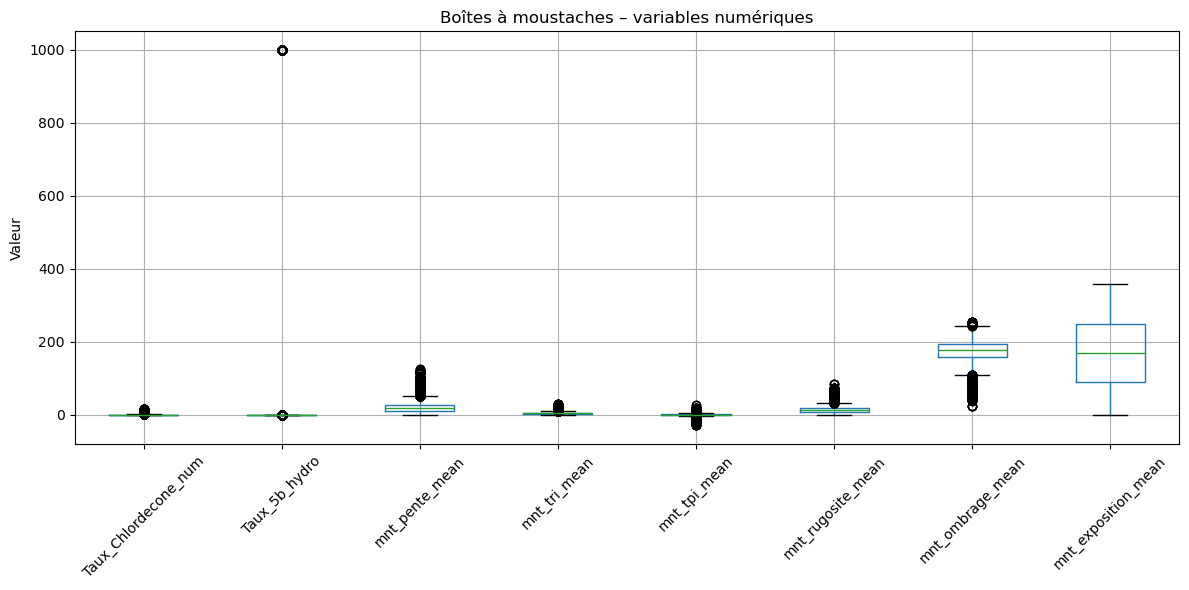

In [11]:
vars_num = [
    "Taux_Chlordecone_num", "Taux_5b_hydro",
    "mnt_pente_mean","mnt_tri_mean","mnt_tpi_mean",
    "mnt_rugosite_mean","mnt_ombrage_mean","mnt_exposition_mean"
]

print(chlordecone[vars_num].describe(percentiles=[.01,.05,.95,.99]).T)


plt.figure(figsize=(12, 6))
chlordecone[vars_num].boxplot(rot=45)
plt.title("Boîtes à moustaches – variables numériques")
plt.ylabel("Valeur")
plt.tight_layout()
plt.show()

### 3.9 Imputation des valeurs aberrantes/manquantes

In [12]:
#Gestion des taux négatifs
chlordecone.loc[chlordecone["Taux_Chlordecone_num"] < 0, "Taux_Chlordecone_num"] = np.nan
chlordecone.loc[chlordecone["Taux_5b_hydro"] < 0, "Taux_5b_hydro"] = np.nan

#Gestion des valeurs "inf"
chlordecone.replace([np.inf, -np.inf], np.nan, inplace=True)

# gestion des pentes négatives
chlordecone.loc[chlordecone["mnt_pente_mean"] < 0, "mnt_pente_mean"] = np.nan


#Taux > 100% impossible
chlordecone.loc[chlordecone["Taux_5b_hydro"] >= 100, "Taux_5b_hydro"] = np.nan

#J'ai capé les données entre les 0.01 et 0.99 centiles pour éviter les valeurs trop extrême
p01, p99 = chlordecone["Taux_Chlordecone_num"].quantile([0.01, 0.99])
chlordecone["Taux_Chlordecone_cap"] = chlordecone["Taux_Chlordecone_num"].clip(p01, p99)

#Pente > 90 % est peu plausible donc j'ai décidé de les enlever
chlordecone.loc[chlordecone["mnt_pente_mean"] > 90, "mnt_pente_mean"] = np.nan

#Le diagnostic des valeurs aberrantes a permis d’identifier à la fois des valeurs extrêmes cohérentes avec la nature des phénomènes étudiés et des valeurs manifestement absurdes liées à des erreurs de codage, qui ont été traitées comme manquantes avant l’analyse.


### 3.10 Ajouts de colonnes + normalisation texte

In [14]:
def classer_pluie(rain):
    match rain:
        case "0-2000":
            return "faible"
        case "2000-3000":
            return "moyenne"
        case _:
            return "élevée"

chlordecone["pluie_cat"] = chlordecone["RAIN"].apply(classer_pluie)

chlordecone["annee_prelevement"] = chlordecone["Date_prelevement"].dt.year
chlordecone["mois_prelevement"] = chlordecone["Date_prelevement"].dt.month

# normalisation de la colonne type sol pour éviter les différences 
chlordecone["type_sol_clean"] = (
    chlordecone["type_sol"]
    .str.lower()
    .str.replace("[^a-zàâçéèêëîïôûùüÿñæœ ]", "", regex=True)
)

In [18]:
chlordecone_propre = chlordecone.copy()

#export de la base complète nettoyée
chlordecone_propre.to_csv(
    "data/dataclean/chlordecone_propre.csv",
    sep=";",
    index=False,
    encoding="utf-8"
)

chlordecone_propre.to_csv(
    "outputs/chlordecone_propre.csv",
    sep=";",
    index=False,
    encoding="utf-8"
)

## 4) Création de tables aggrégées


### 4.1 Table parcelles (agrégation par ID)

Objectif : **1 ligne = 1 parcelle**.


In [109]:
df_parcelle = (
    chlordecone_propre
    .groupby("ID", as_index=False)
    .agg(
        commune=("COMMU_LAB", "first"),
        sol_simple=("Sol_simple", "first"),
        pluie=("RAIN", "first"),
        taux_moyen=("Taux_Chlordecone_num", "mean"),
        taux_med=("Taux_Chlordecone_num", "median"),
        pente_moy=("mnt_pente_mean", "mean"),
        tri_moy=("mnt_tri_mean", "mean"),
        tpi_moy=("mnt_tpi_mean", "mean"),
        rug_moy=("mnt_rugosite_mean", "mean"),
        omb_moy=("mnt_ombrage_mean", "mean"),
        expo_moy=("mnt_exposition_mean", "mean"),
        X=("X", "mean"),
        Y=("Y", "mean"),
        nb_mesures=("Taux_Chlordecone_num", "count"),
        histo_banane=("histoBanane_Histo_ban","first")
    )
)

df_parcelle.head()



# Transformer depuis UTM 20N vers WGS84 (lon/lat)
transformer = Transformer.from_crs(
    "EPSG:32620",  # UTM zone 20N
    "EPSG:4326",   # WGS84 (lon, lat)
    always_xy=True
)

# Conversion des projection en coordonnées longitude/latitude
lon, lat = transformer.transform(
    df_parcelle["X"].values,
    df_parcelle["Y"].values
)

# Ajout au df_parcelle
df_parcelle["longitude"] = lon
df_parcelle["latitude"] = lat

df_parcelle[["X", "Y", "longitude", "latitude"]].head()
df_parcelle_export = df_parcelle.copy()
df_parcelle_export.to_csv(
    "outputs/parcelles_resultats.csv",
    index=False
)


### 4.2 Définition d’un niveau de risque (Top 10%)

J'ai choisi de classer les 10% de parcelles aux **taux moyens** les plus élevés comme étant "Élevé".


In [110]:
#J'ai consideré les 10% desparcelles les plus contaminées comme ayant un risque elevé afin de pouvoir créer un seuil de risque
seuil_risque = df_parcelle["taux_moyen"].quantile(0.90)

df_parcelle["niveau_risque"] = df_parcelle["taux_moyen"].apply(
    lambda x: "élevé" if x >= seuil_risque else "modéré"
)



### 4.3 Table communes

In [111]:
# Table commune (1 ligne = 1 commune) - basée sur df_parcelle pour éviter le biais du nb de mesures
df_communes = (
    df_parcelle
    .dropna(subset=["commune"])
    .groupby("commune", as_index=False)
    .agg(
        nb_parcelles=("ID", "count"),
        taux_moy_commune=("taux_moyen", "mean"),
        taux_med_commune=("taux_moyen", "median"),
        part_risque_eleve=("niveau_risque", lambda s: (s=="Élevé (Top 10%)").mean())
    )
    .sort_values("taux_moy_commune", ascending=False)
)


### 4.4 Jointure entre parcelle et communes

In [112]:
#on joint les table parcelle et commune afin d'ajouter dans la table parcelle le taux moyen_commune
df_parcelle = df_parcelle.merge(
    df_communes,
    on="commune",
    how="left"
)


### 4.5 Table sols

In [113]:
df_sols = (
    chlordecone_propre
    .groupby("Sol_simple", as_index=False)
    .agg(
        nb_mesures=("Taux_Chlordecone_num","count"),
        nb_parcelles=("ID","nunique"),
        taux_moyen=("Taux_Chlordecone_num","mean"),
        taux_median=("Taux_Chlordecone_num","median"),
    )
    .sort_values("taux_moyen", ascending=False)
)


### 4.5 Table évolution temporelle

In [114]:
df_evol_annee = (
    chlordecone_propre
    .dropna(subset=["Date_prelevement"])
    .assign(annee=lambda d: d["Date_prelevement"].dt.year)
    .groupby("annee", as_index=False)
    .agg(
        nb_mesures=("Taux_Chlordecone_num","count"),
        nb_parcelles=("ID","nunique"),
        taux_moyen=("Taux_Chlordecone_num","mean"),
        taux_median=("Taux_Chlordecone_num","median"),
        p90=("Taux_Chlordecone_num", lambda s: s.quantile(0.90)),
        sol_simple=("Sol_simple", "first"),
    )
    .sort_values("annee")
)

df_evol_annee.head()

df_evol_mois = (
    chlordecone_propre
    .dropna(subset=["Date_prelevement"])
    .assign(mois=lambda d: d["Date_prelevement"].dt.to_period("M").astype(str))
    .groupby("mois", as_index=False)
    .agg(
        nb_mesures=("ID", "count"),
        nb_parcelles=("ID", "nunique"),
        taux_moyen=("Taux_Chlordecone_num", "mean"),
        taux_median=("Taux_Chlordecone_num", "median"),
        sol_simple=("Sol_simple", "first"),
    )
    .sort_values("mois")
)

## 5) Analyses utiles

### 5.1 Localisation des parcelles à risques

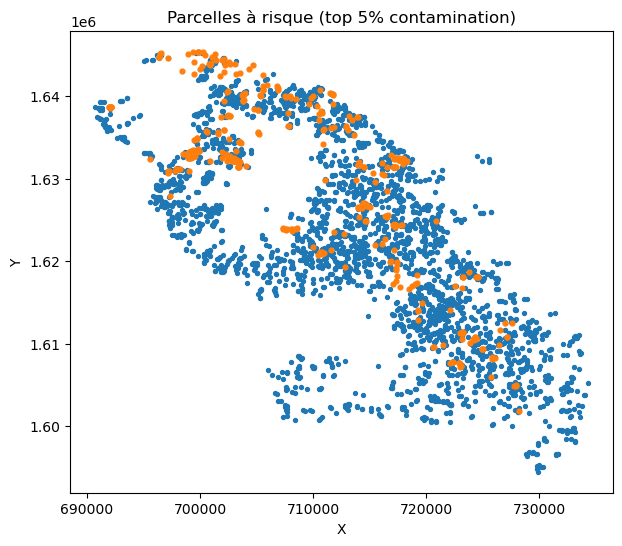

In [115]:
# où se situent les parcelles à risques 
seuil_95 = df_parcelle["taux_moyen"].quantile(0.90)
df_parcelle["risque_95"] = df_parcelle["taux_moyen"].ge(seuil_95)

plt.figure(figsize=(7,6))
plt.scatter(df_parcelle.loc[~df_parcelle["risque_95"], "X"],
            df_parcelle.loc[~df_parcelle["risque_95"], "Y"], s=8)
plt.scatter(df_parcelle.loc[df_parcelle["risque_95"], "X"],
            df_parcelle.loc[df_parcelle["risque_95"], "Y"], s=12)
plt.title("Parcelles à risque (top 10% contamination)")
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

### 5.2 Résumé global par parcelles

count    3610.000000
mean        0.304073
std         1.091765
min         0.000500
1%          0.000500
5%          0.000500
50%         0.001650
95%         1.705500
99%         5.292900
max        17.350000
Name: taux_moyen, dtype: float64


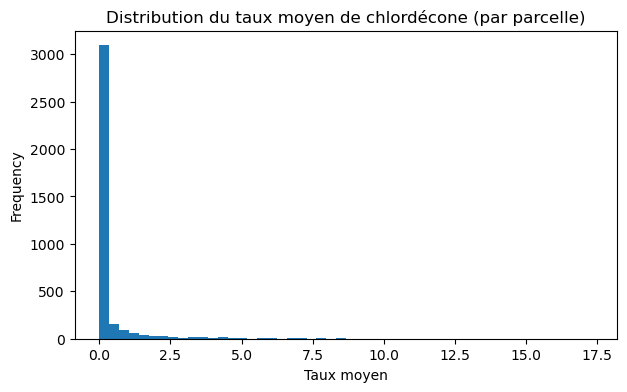

In [116]:
# Résumé global parcelles
print(df_parcelle["taux_moyen"].describe(percentiles=[.01,.05,.5,.95,.99]))

# Histogramme des taux 
plt.figure(figsize=(7,4))
df_parcelle["taux_moyen"].dropna().plot(kind="hist", bins=50)
plt.title("Distribution du taux moyen de chlordécone (par parcelle)")
plt.xlabel("Taux moyen")
plt.show()

### 5.3 Analyse du taux de chlordécone par types de sol

sol_simple
Andosol                977
Vertisol               910
Ferralsol              736
Nitisol                457
No data                278
Alluvium, Colluvium    133
Urban area             119
Name: count, dtype: int64
pluie
2000-3000    2138
1500-2000    1155
1250-1500     257
0-1250         60
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

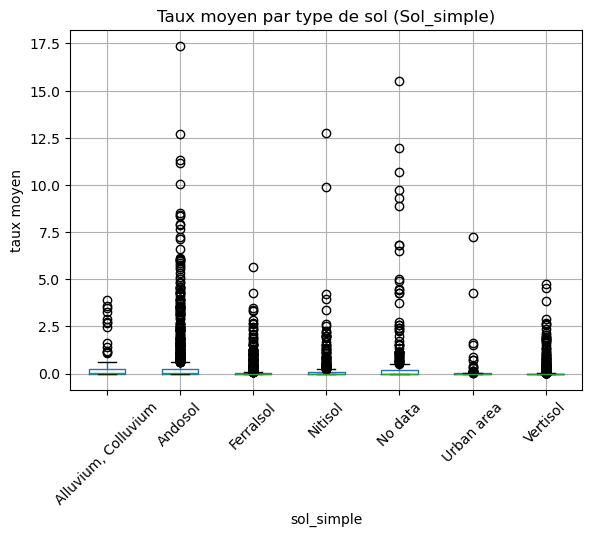

,sol_simple,nb,taux_moy,taux_med
4,No data,278,0.620784,0.00165
1,Andosol,977,0.565040,0.00520
0,"Alluvium, Colluvium",133,0.327100,0.01700
3,Nitisol,457,0.233636,0.00165
5,Urban area,119,0.163285,0.00165
2,Ferralsol,736,0.151737,0.00165
6,Vertisol,910,0.100765,0.00165


In [117]:
# Nombre de modalités
print(df_parcelle["sol_simple"].value_counts(dropna=False).head(15))
print(df_parcelle["pluie"].value_counts(dropna=False))

# Boxplot taux par sol 
plt.figure(figsize=(10,5))
df_parcelle.boxplot(column="taux_moyen", by="sol_simple", rot=45)
plt.title("Taux moyen par type de sol (Sol_simple)")
plt.suptitle("")
plt.ylabel("taux moyen")
plt.show()

# Moyenne par sol 
sol_stats = (
    df_parcelle.groupby("sol_simple", as_index=False)
    .agg(nb=("ID","count"), taux_moy=("taux_moyen","mean"), taux_med=("taux_moyen","median"))
    .sort_values("taux_moy", ascending=False)
)
sol_stats.head(10)

### 5.4 Evolution du taux de Chlordécone par année

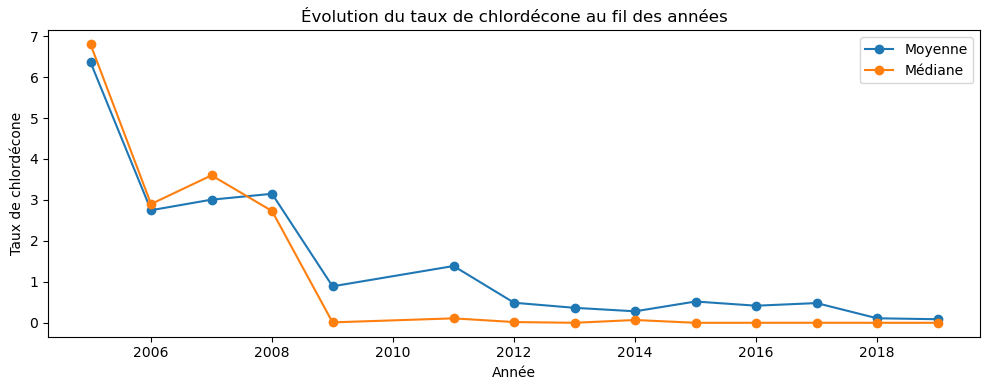

In [118]:
plt.figure(figsize=(10,4))
plt.plot(df_evol_annee["annee"], df_evol_annee["taux_moyen"], marker="o", label="Moyenne")
plt.plot(df_evol_annee["annee"], df_evol_annee["taux_median"], marker="o", label="Médiane")
plt.title("Évolution du taux de chlordécone au fil des années")
plt.xlabel("Année")
plt.ylabel("Taux de chlordécone")
plt.legend()
plt.tight_layout()
plt.show()

## 5) ACP et Clustering

## 5.1 Analyse en Composantes Principales (ACP)

### Objectif

Afin de mettre en évidence d’éventuelles structures globales entre les parcelles, j'ai réalisé une Analyse en Composantes Principales (ACP).

J'ai retenu les variables quantitatives suivantes :
- la pente moyenne (`pente_moy`),
- le taux moyen de chlordécone (`taux_moyen`),
- les coordonnées spatiales (`X`, `Y`).

J'ai retenu ces variables, car elles permettent de combiner l’information sur la contamination, la topographie et la localisation spatiale des parcelles.  
J'ai également normalisé les variables pour les rendre comparable.

Variance expliquée : [0.44304043 0.25158998]


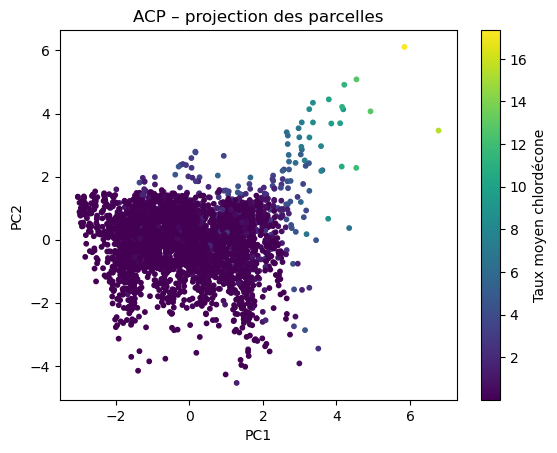

In [119]:
vars_num = [
    "pente_moy",
    "taux_moyen",
    "X",
    "Y"
]

X = df_parcelle[vars_num].dropna()

# normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = X.copy()
df_pca["PC1"] = X_pca[:,0]
df_pca["PC2"] = X_pca[:,1]

print("Variance expliquée :", pca.explained_variance_ratio_)

plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["taux_moyen"], s=10)
plt.colorbar(label="Taux moyen chlordécone")
plt.title("ACP – projection des parcelles")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Variance expliquée
Les deux premières composantes principales expliquent respectivement :
- **PC1 : environ 44 % de la variance**,  
- **PC2 : environ 25 % de la variance**.

Ainsi, les deux premières composantes expliquent **près de 69 % de la variance totale**, ce qui indique que l’ACP fournit une représentation synthétique assez satisfaisante des données, sans perte excessive d’information.

### Analyse de la projection des parcelles
La projection des parcelles sur ctoriel (PC1, PC2) met en évidence une forte concentration de points autour de l’origine, correspondant à des parcelles présentant des caractéristiques proches et des niveaux de contamination relativement faibles.

À l’inverse, certaines parcelles apparaissent plus éloignées du centre, principalement le long de l’axe PC1. Ces parcelles sont associées à des **taux moyens de chlordécone plus élevés**, comme l’indique la coloration du nuage de points.

La première composante principale semble ainsi capter un **gradient de contamination**, combiné à des caractéristiques spatiales et topographiques. La seconde composante principale joue un rôle plus secondaire, permettant de différencier certaines parcelles sans structuration aussi marquée.

### Interprétation générale
L’ACP met en évidence une structuration globale des parcelles, suggérant que les parcelles les plus contaminées présentent des caractéristiques distinctes de celles faiblement contaminées.  
Cette analyse confirme que la contamination n’est pas répartie de manière totalement aléatoire, mais qu’elle s’inscrit dans  idimensionnelle liée aux variables étudiées.

### Limites de l’analyse
Cette analyse reste exploratoire. L’ACP ne permet pas d’établir de relations causales entre les variables, mais uniquement de mettre en évidence des tendances et des structures globales dans les données. Les résultats dépendent également du cque j'ai hoix devariables intégrées à l’analyse.


### 5.2 K-Means

C:\Users\theor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\theor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


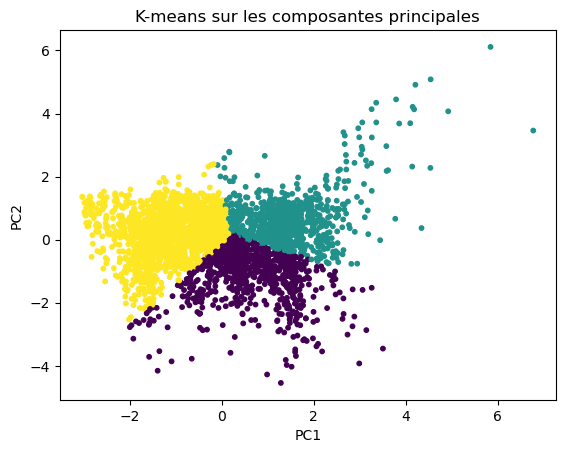

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,947.0,0.112558,0.370709,0.0005,0.00050,0.00165,0.019750,4.426
1,905.0,0.902163,1.973236,0.0005,0.00165,0.02590,0.776000,17.350
2,1758.0,0.099348,0.353638,0.0005,0.00050,0.00165,0.011025,4.754


In [120]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_pca)

df_pca["cluster"] = clusters

plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["cluster"], s=10)
plt.title("K-means sur les composantes principales")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Profil des clusters
df_pca.groupby("cluster")["taux_moyen"].describe()

**Analyse**

Le clustering k-means appliqué aux composantes principales met en évidence trois groupes distincts de parcelles, clairement séparés dans l’espace (PC1, PC2), comme l’illustre la différenciation par couleurs.

Le **cluster jaune** regroupe des parcelles majoritairement situées à gauche du plan factoriel. Ces parcelles présentent des taux de chlordécone faibles, avec une dispersion relativement limitée, traduisant un profil de contamination faible et homogène.

Le **cluster violet**, situé principalement dans la partie basse du graphique, correspond également à des parcelles faiblement contaminées, mais avec une variabilité légèrement plus importante que le cluster jaune. Il représente un second profil de contamination faible à modérée.

Le **cluster bleu-vert** se distingue des deux autres. Il regroupe des parcelles associées à des taux moyens de chlordécone plus élevés, comme le confirment la moyenne et le maximum observés dans les statistiques descriptives. Ce cluster présente également une dispersion plus importante, traduisant une plus grande hétérogénéité des parcelles les plus contaminées.

Dans l’ensemble, la distinction visuelle entre les clusters confirme les résultats de l’ACP : la contamination n’est pas répartie de manière uniforme, mais s’organise en groupes distincts, principalement différenciés par le niveau de chlordécone.  
Le clustering permet ainsi d’identifier clairement un groupe de parcelles à contamination élevée, bien distinct des parcelles faiblement contaminées.
 contaminées.
x étudiés.


### 5.3 Classification Ascendante Hiérarchique (CAH)

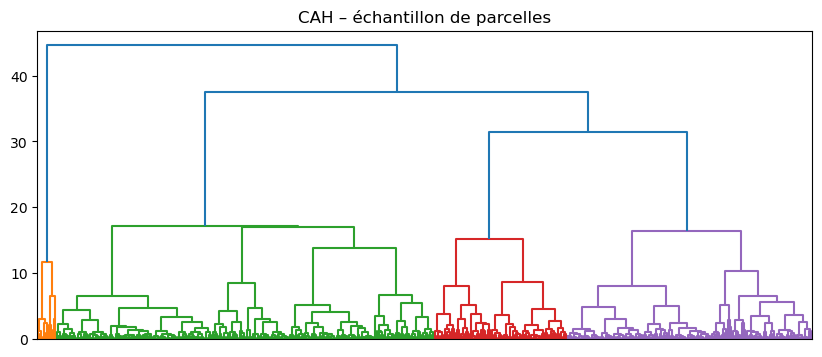

In [121]:
Z = linkage(X_scaled[:500], method="ward")  # échantillon

plt.figure(figsize=(10,4))
dendrogram(Z, no_labels=True)
plt.title("CAH – échantillon de parcelles")
plt.show()


**Analyse**

La CAH, réalisée à partir d’un échantillon de parcelles et selon la méthode de Ward, met en évidence une structuration hiérarchique claire des données, comme l’illustre le dendrogramme ci-dessus.

Le dendrogramme montre plusieurs groupes bien distincts, caractérisés par des fusions à des niveaux de distance relativement élevés. Cela indique l’existence de clusters naturellement séparés, présentant des caractéristiques différentes en termes de contamination et de variables associées.

On observe notamment **trois grands groupes principaux**, visibles par les branches colorées du dendrogramme. Ces groupes correspondent à des profils de parcelles distincts, confirmant l’hétérogénéité des parcelles observée lors de l’ACP et du k-means.

Les fusions tardives (à des hauteurs élevées sur le dendrogramme) montrent des différences marquées entre les groupes, tandis que les fusions précoces correspondent à des parcelles aux caractéristiques proches.

Dans l’ensemble, la CAH confirme l’existence de structures non aléatoires dans les données et vient renforcer les résultats obtenus par les méthodes précédentes. Elle permet de visualiser la hiérarchie des regroupements et de conforter le choix d’un nombre limité de clusters.
clusters.


## 6) Tests statistiques et inférence

Afin de compléter les analyses exploratoires et multivariées, j'ai également réalisé des tests statistiques pour évaluer de manière formelle l’existence de différences et de relations entre certaines variables. Ces tests m'ont permis de vérifier si les tendances observées graphiquement sont statistiquement significatives et ne relèvent pas du hasard.

### 6.1 Test de Kruskal-Wallis

In [122]:
# Groupes de taux par sol (parcelle)
groups = [g["taux_moyen"].dropna().values for _, g in df_parcelle.groupby("sol_simple") if g["taux_moyen"].notna().sum() > 20]

stat, p = kruskal(*groups)
print("Kruskal-Wallis (taux ~ sol_simple): stat=", stat, "p-value=", p)

Kruskal-Wallis (taux ~ sol_simple): stat= 309.45224868686313 p-value= 7.709191861607877e-64


**Analyse - Taux de chlordécone selon le type de sol**

J'ai utilisé ce test afin de comparer les distributions du taux moyen de chlordécone entre les différents types de sols. Ce test est adapté au contexte, les taux de chlordécone ne suivent pas une distribution normale et présentant des valeurs extrêmes.

Le résultat du test met en évidence une p-value extrêmement faible (p-value < 0,001), indiquant une différence statistiquement significative entre les taux de chlordécone selon le type de sol.  

Cela signifie que les niveaux de contamination observés varient de manière significative d’un type de sol à l’autre. Le type de sol apparaît ainsi comme un facteur associé aux niveaux de contamination en chlordécone qu'il sera notamment nécessaire de prendre en compte dans l'aide à la décision.

### 6.2 Test du Khi-deux

In [123]:
df_test = df_parcelle.dropna(subset=["sol_simple","taux_moyen"]).copy()
seuil = df_test["taux_moyen"].quantile(0.90)
df_test["risque_90"] = df_test["taux_moyen"].ge(seuil)

cont = pd.crosstab(df_test["sol_simple"], df_test["risque_90"])
chi2, p, dof, exp = chi2_contingency(cont)
print("Chi2 sol_simple vs risque_90: chi2=", chi2, "p-value=", p)

Chi2 sol_simple vs risque_90: chi2= 109.80628024405573 p-value= 2.2379509384828773e-21


**Analyse – Type de sol et appartenance aux parcelles les plus contaminées**

Le test du Khi-deux a permis d’étudier la relation entre le type de sol (`sol_simple`) et l’appartenance aux parcelles les plus contaminées. Les parcelles à risque élevé ont été définies ici comme les 10 % de parcelles présentant les taux moyens de chlordécone les plus élevés.

Le résultat du test met en évidence une p-value extrêmement faible (p-value < 0,001), indiquant l’existence d’une association statistiquement significative entre le type de sol et l’appartenance aux parcelles les plus contaminées.

Ce résultat signifie que la probabilité d’appartenir aux parcelles à forte contamination dépend du type de sol. Autrement dit, certains types de sols sont surreprésentés parmi les parcelles présentant des niveaux élevés de chlordécone, ce qui suggère un lien entre les caractéristiques des sols et la contamination observée.

Ce test vient ainsi renforcer les conclusions issues des analyses exploratoires et multivariées, en apportant une validation statistique formelle des différences observées entre les types de sols.
 sols.
écone.


### Conclusion des tests statistiques

Ces tests statistiques confirment les résultats issus des analyses exploratoires et multivariées. Ils apportent une validation statistique aux différences observées et renforcent l’idée que la contamination en chlordécone n’est pas distribuée de manière aléatoire, mais qu’elle est associée à certaines caractéristiques notamment concernant les types de sols.


## 7) Exports Power BI

**5 tables** :
- `parcelles_resultats.csv`
- `evolution_mois.csv`
- `communes_resultats.csv`
- `evolution_annee.csv` 
- `powerbi_sols.csv`


In [124]:
df_commune_export = df_communes.copy()
df_commune_export.to_csv(
    "outputs/communes_resultats.csv",
    index=False
)

df_parcelle_export = df_parcelle.copy()
df_parcelle_export.to_csv(
    "outputs/parcelles_resultats.csv",
    index=False
)

df_sols_export = df_sols.copy()
df_sols_export.to_csv(
    "outputs/sols_resultats.csv",
    index=False
)


df_evol_annee.to_csv("outputs/evolution_annee.csv", index=False, encoding="utf-8")
df_evol_mois.to_csv("outputs/evolution_mois.csv", index=False, encoding="utf-8")


## 7) Conclusion 

Ce projet a permis de mettre en œuvre l’ensemble des étapes d’un pipeline complet d’analyse de données, depuis la préparation et le nettoyage des données jusqu’à l’analyse statistique et multivariée. 

La phase de data preparation a permis de fiabiliser les données, de traiter les valeurs manquantes, censurées et aberrantes, et de structurer les informations à différentes échelles (parcelle, commune, type de sol).

Les analyses exploratoires ont mis en évidence des disparités importantes dans les niveaux de contamination en chlordécone, notamment selon les types de sols et les territoires. Ces constats ont été approfondis à l’aide de méthodes multivariées (ACP, k-means, CAH), qui ont révélé l’existence de profils distincts de parcelles, confirmant que la contamination n’est pas distribuée de manière homogène.

Les tests statistiques ont ont validés les résultats observés, en démontrant que les différences de contamination selon les types de sols et l’appartenance aux parcelles les plus contaminées sont statistiquement significatives. L’ensemble de ces analyses converge vers l’idée que certains contextes environnementaux et territoriaux sont plus exposés que d’autres.

Pour aider à la décision, l’ensemble des résultats est synthétisé et présenté dans un tableau de bord Power BI ainsi que dans la synthèse finale permettant de visualiser les principaux résultats